In [1]:
import os
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from lxml import html
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import safe_get_stop_words
from wordcloud import WordCloud
from IPython.display import HTML
import base64
import time

In [2]:
## LIST ASIN
asins = ['B00SMBG8QY']

In [3]:
def scrape_reviews(asins):
    ratings_dict = {}
    reviews_list = []
    reviews_df = pd.DataFrame()

    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.90 Safari/537.36'}
    XPATH_REVIEWS = '//div[@data-hook="review"]'
    XPATH_REVIEW_COUNT = '//span[contains(@class, "totalReviewCount")]//text()'
    XPATH_REVIEW_RATING = './/i[@data-hook="review-star-rating"]//text()'
    XPATH_REVIEW_HEADER = './/a[@data-hook="review-title"]//text()'
    XPATH_REVIEW_AUTHOR = './/a[@data-hook="review-author"]//text()'
    XPATH_REVIEW_DATE = './/span[@data-hook="review-date"]//text()'
    XPATH_REVIEW_BODY = './/span[@data-hook="review-body"]//text()'
    XPATH_REVIEW_HELPFUL = './/span[@data-hook="helpful-vote-statement"]//text()'

    p_num = 0
    for asin in asins:
        while True:
            if p_num % 5 == 0:
                print('Scraping page {}'.format(p_num))
            amazon_url = 'https://www.amazon.com/product-reviews/' + asin + '?pageNumber=' + str(p_num) + '&sortBy=recent'
            # Add some recent user agent to prevent amazon from blocking the request 
            # Find some chrome user agent strings  here https://udger.com/resources/ua-list/browser-detail?browser=Chrome
            try:
                page = requests.get(amazon_url, headers=headers)
            except:
                for i in range(4):
                    print('now sleeping {}'.format(90 - 30*i))
                    time.sleep(30)
                page = requests.get(amazon_url, headers=headers)
            page_response = page.text.encode('utf-8')

            parser = html.fromstring(page_response)

            reviews = parser.xpath(XPATH_REVIEWS)
            review_count = int(parser.xpath(XPATH_REVIEW_COUNT)[0].replace(',', ''))

            num_pages = (review_count // 10) + 1
            if not len(reviews) > 0:
                break
            # Parsing individual reviews
            for review in reviews:
                raw_review_author = review.xpath(XPATH_REVIEW_AUTHOR)
                raw_review_rating = review.xpath(XPATH_REVIEW_RATING)
                raw_review_header = review.xpath(XPATH_REVIEW_HEADER)
                raw_review_date = review.xpath(XPATH_REVIEW_DATE)
                raw_review_body = review.xpath(XPATH_REVIEW_BODY)
                raw_review_helpful = review.xpath(XPATH_REVIEW_HELPFUL)

                review_dict = {
                    'review_text': raw_review_body,
                    'review_posted_date': raw_review_date,
                    'review_header': raw_review_header,
                    'review_rating': raw_review_rating,
                    'review_helpful': raw_review_helpful,
                    'review_author': raw_review_author
                }
                reviews_df = reviews_df.append(review_dict, ignore_index=True)
            p_num += 1
            if p_num % 5 == 0:
                time.sleep(2)
            if p_num % 50 == 0:
                time.sleep(15) 
            time.sleep(0.5)
            if p_num > num_pages:
                break
    return reviews_df

print('Scraping reviews')
reviews_df = scrape_reviews(asins)
print('Scraped {} reviews'.format(len(reviews_df)))

Scraping reviews
Scraping page 0
Scraping page 1
Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Scraping page 6
Scraping page 7
Scraping page 8
Scraping page 9
Scraping page 10
Scraping page 11
Scraping page 12
Scraping page 13
Scraping page 14
Scraping page 15
Scraping page 16
Scraping page 17
Scraping page 18
Scraping page 19
Scraping page 20
Scraping page 21
Scraping page 22
Scraping page 23
Scraping page 24
Scraping page 25
Scraping page 26
Scraping page 27
Scraping page 28
Scraping page 29
Scraping page 30
Scraping page 31
Scraping page 32
Scraping page 33
Scraping page 34
Scraping page 35
Scraping page 36
Scraping page 37
Scraping page 38
Scraping page 39
Scraping page 40
Scraping page 41
Scraping page 42
Scraping page 43
Scraping page 44
Scraping page 45
Scraping page 46
Scraping page 47
Scraping page 48
Scraping page 49
Scraping page 50
Scraping page 51
Scraping page 52
Scraping page 53
Scraping page 54
Scraping page 55
Scraping page 56
Scraping page 57
Scrapin

In [4]:
for col in reviews_df.columns:
    reviews_df[col] = reviews_df[col].apply(lambda x: '\n'.join(x))

reviews_df['review_helpful'] = (reviews_df['review_helpful']
                                .str.replace('One', '1')
                                .str.replace(r'[^0-9]', ''))
reviews_df['review_helpful'].loc[reviews_df['review_helpful'] == ''] = '0'
reviews_df['review_helpful'] = reviews_df['review_helpful'].astype(int)

reviews_df['review_posted_date'] = pd.to_datetime(reviews_df['review_posted_date']
                                                  \
                                                  .str.strip('on'))

reviews_df['review_rating'] = reviews_df['review_rating'].str.strip('out of 5 stars').astype(float)
reviews_df.loc[reviews_df['review_rating'] == 0, 'review_rating'] = 5

reviews_df['review_length'] = reviews_df['review_text'].apply(lambda x: len(x))

reviews_df.drop_duplicates(inplace=True)

## Histogram of Reviews' Lengths

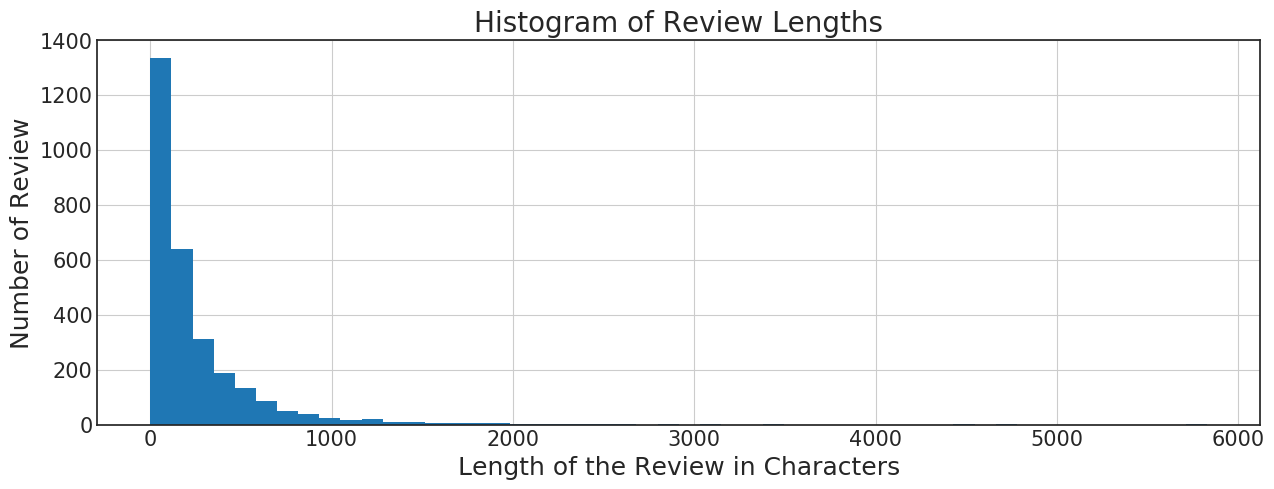

In [5]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-white')
plt.figure(figsize=(15, 5))
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)

axes = reviews_df['review_length'].hist(bins=50)
# axes.set_xlim(0, 2500)
plt.title('Histogram of Review Lengths', fontsize=20)
plt.xlabel('Length of the Review in Characters', fontsize=18)
plt.ylabel('Number of Review', fontsize=18)
plt.show()

## Histogram of Ratings

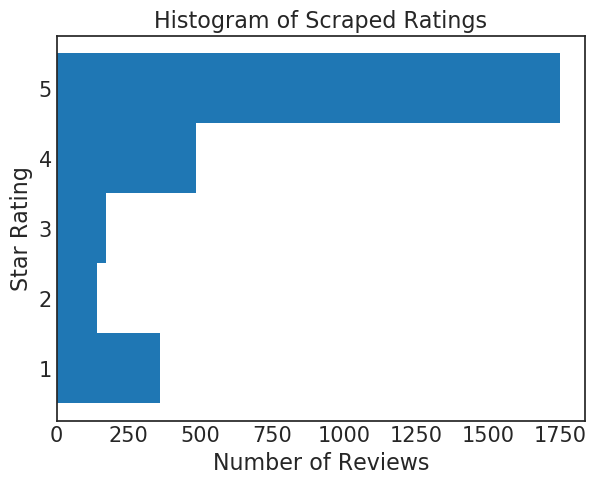

In [6]:
plt.style.use('seaborn-white')

fig = plt.figure()
fig.set_size_inches(15, 5)

a = fig.add_subplot(1, 2, 1)

mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
a.hist(reviews_df['review_rating'], bins=np.arange(1, 7) - 0.5, orientation="horizontal")

plt.title('Histogram of Scraped Ratings', fontsize=16)
plt.ylabel('Star Rating', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=16)

plt.show()

## Histogram of Review Dates

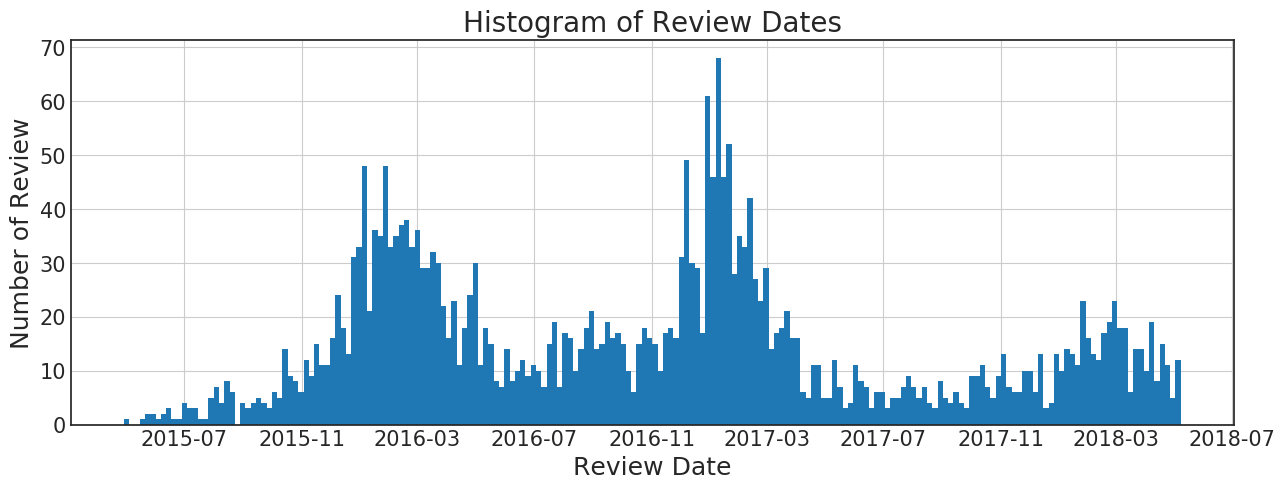

In [7]:
plt.style.use('seaborn-white')
plt.figure(figsize=(15, 5))
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
axes = reviews_df['review_posted_date'].hist(bins=200)
plt.title('Histogram of Review Dates', fontsize=20)
plt.xlabel('Review Date', fontsize=18)
plt.ylabel('Number of Review', fontsize=18)
plt.show()

## Length of the review vs. the number of people who found it helpful

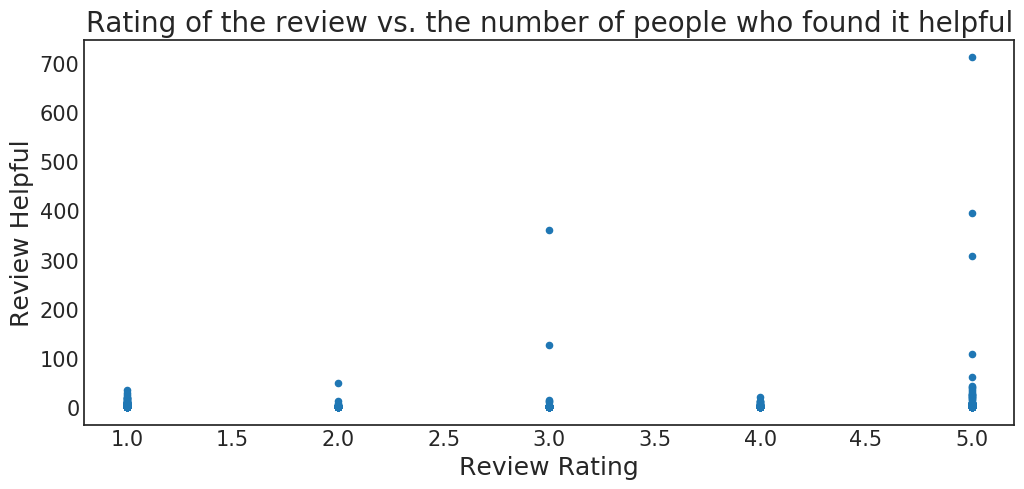

In [8]:
plt.style.use('seaborn-white')
fig = plt.figure()
fig.set_size_inches(12, 5)
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
a = fig.add_subplot(1, 1, 1)

a = reviews_df.dropna(subset=['review_rating', 'review_helpful']).plot.scatter('review_rating',
                                                                                       'review_helpful', ax=a)

plt.title('Rating of the review vs. the number of people who found it helpful', fontsize=20)
plt.xlabel('Review Rating', fontsize=18)
plt.ylabel('Review Helpful', fontsize=18)
plt.show()

## Common Words & Phrases

In [169]:
def make_word_cloud(df, ngram_min, ngram_max, stop_words):
    plt.style.use('seaborn-white')

    fig = plt.figure()
    fig.set_size_inches(15, 10)

    for ind, row in df.iterrows():
        data = row['review_text']
        min_df = int(max([min([9, 0.01 * len(data)]), 2]))
        num_words = 200
        ngram_range = (ngram_min, ngram_max)
        if ngram_min > 3:
            stop_words = None

        count_vectorizer = CountVectorizer(min_df=min_df,
                                           max_df=0.9,
                                           token_pattern=r"\b\w[\w']+\b",
                                           lowercase=True,
                                           stop_words=stop_words,
                                           max_features = 20,
                                           ngram_range=ngram_range)
        counts = count_vectorizer.fit_transform(data)
        counts = counts.toarray().sum(axis=0)
        count_weighting = dict(zip(count_vectorizer.get_feature_names(), counts))
        count_weighting_df = pd.DataFrame.from_dict(count_weighting, orient='index')
        count_weighting_df = count_weighting_df.reset_index(drop=False)
        count_weighting_df.columns = ['word', 'count']

        count_weighting_df = count_weighting_df.sort_values(['count'], ascending=False)
        count_weighting_df = count_weighting_df.set_index('word')

        word_cloud_freq = count_weighting_df['count'].head(num_words).to_dict()
        wordcloud = WordCloud(collocations=False).generate_from_frequencies(word_cloud_freq)
        a = fig.add_subplot(3, 1, ind + 1)
        plt.title(str(row['rating_text']), fontsize=20)
        plt.imshow(wordcloud, cmap=plt.cm.bone, interpolation='bilinear')
        plt.axis("off")
    plt.show()

In [170]:
stop_words = safe_get_stop_words('en')
stop_words.extend([
    'sound',
    'bar',
    'vizio'
#     'amazon',
#     'just',
#     'get',
#     'will',
#     'use'
    ])

reviews_df['rating_text'] = None
reviews_df['rating_text'].loc[reviews_df['review_rating'] < 3] = '1 or 2 stars'
reviews_df['rating_text'].loc[reviews_df['review_rating'] == 3] = '3 stars'
reviews_df['rating_text'].loc[reviews_df['review_rating'] >= 4] = '4 or 5 stars'
reviews_by_rating = reviews_df.groupby('rating_text')['review_text'].apply(list)
reviews_by_rating = reviews_by_rating.reset_index(drop=False)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## One Word

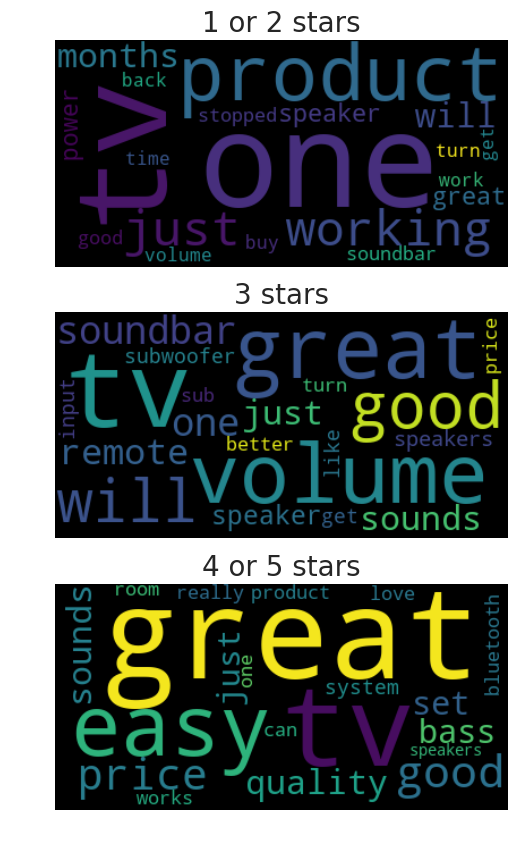

In [171]:
make_word_cloud(reviews_by_rating, 1, 1, stop_words)

## Two Words

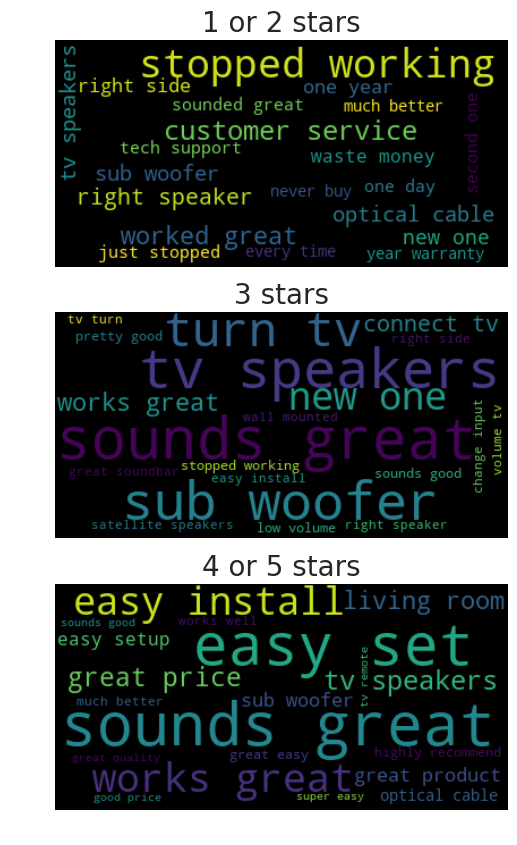

In [172]:
try: make_word_cloud(reviews_by_rating, 2, 2, stop_words)
except: print('No common 2 word phrases found')

## Three Words

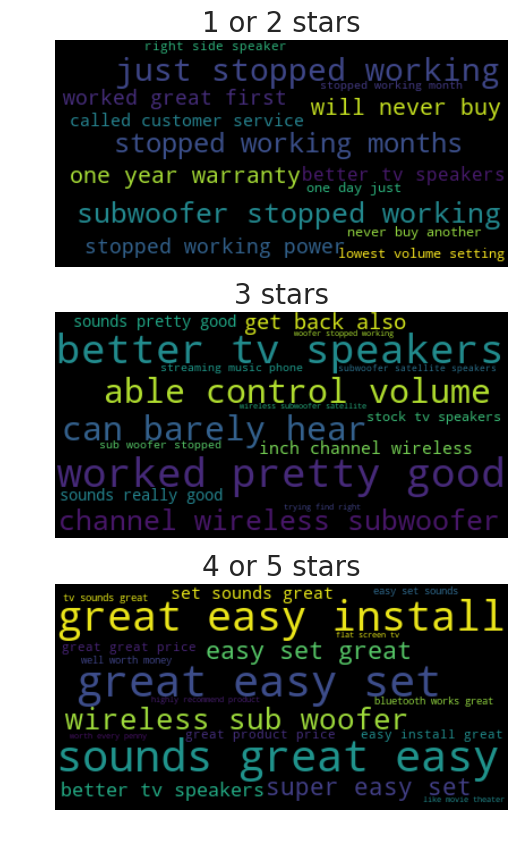

In [173]:
try: make_word_cloud(reviews_by_rating, 3, 3, stop_words)
except: print('No common 3 word phrases found')

## Four or more words

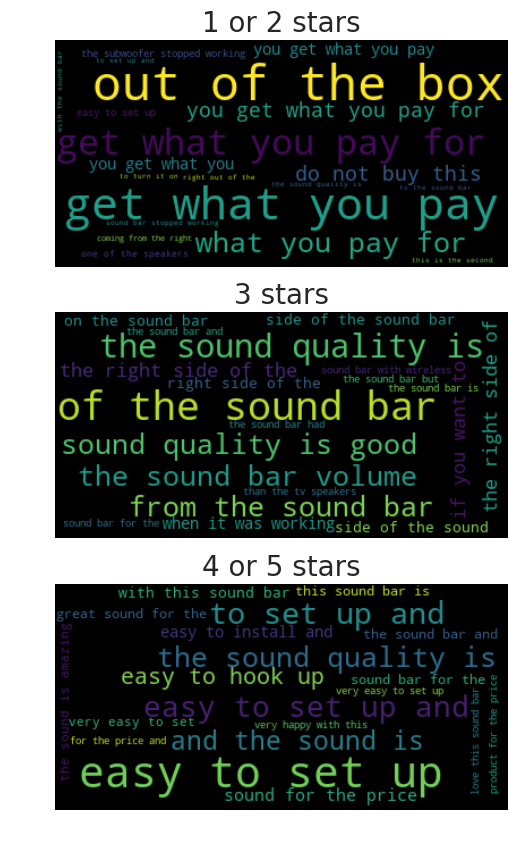

In [174]:
try: make_word_cloud(reviews_by_rating, 4, 10, stop_words)
except: print('No common 4-10 word phrases found')

## Most Helpful Reviews

In [207]:
for rv, row in reviews_df.sort_values(by='review_helpful', ascending=False)[:10].iterrows():
    print('Helpful Votes: ', row['review_helpful'])
    print('Product Rating: ', row['review_rating'])
    print('Review Date: ', row['review_posted_date'])
    print(row['review_text'])
    print('\n')

Helpful Votes:  713
Product Rating:  5.0
Review Date:  2015-06-29 00:00:00
I was looking for a great sound bar to go with the new 50 inch LED tv I'd purchased.  Prices for stereo surround systems can run from a few hundred up into the thousands and I personally wasn't looking to spend that much.  I wanted something that was better than my tv's speakers without the price of a premium system.  I read a LOT of reviews before deciding on this new VIZIO sound bar.  Amazon was offering an extra $30 off the normal price for Prime members and I couldn't beat $148 for this system anywhere.  This sound gets great reviews from a lot of techies and I can honestly say that it's a great system.  It's not just a great sound bar for the money.  Instead, this sound bar beats other costing WAY more than this.  It has a solid construction, a wireless bluetooth subwoofer and a remote control.  To test this sound bar, I played lots of movies (like Godzilla, Transformers and anything else with lots of high 

## Download Reviews in CSV

In [14]:
from IPython.display import HTML
import base64  

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(reviews_df)